In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#--export--#
from exports.e_09_Hooks import *

In [47]:
kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = nn.Sequential(*cnn_layers(data_w, kernel_ns))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

# Fixing our Model

First, we'll implement Kaiming initialization. https://arxiv.org/pdf/1502.01852.pdf

## Brief explaination:

For independent random variables $X_1$ and $X_2$, it's easy to show that the variance of their sum is given by:

$var[X_1 + X_2] = var[X_1] + var[X_2]$

and for two indep rand vars $X$ and $W$:

$var[XW] = var[X]var[W]$

Now, suppose we had $n$ inputs to our model, $x_i$, which are (as per convention) normalized to have a mean of zero and a stddev (thus variance) of 1.

The first layer of our network applies the linear equation:

$\begin{align}
    y_i &= \sum w_{ij}x_j + b_i
     \\ &= w_{i1}x_1 + ... + w_{in} + b_i
\end{align}$


_**An interesting thought: We assume the inputs and weights are independent (while this sounds reasonable for the weights, would this necessarily hold for the inputs?**_

The variance of each $w_{ij}x_j$ will be $var[w_{ij}]$ from above and the fact that $var[x_j]$ = 1. The variance of the sum is then $n$ _times_ $var[w_{ij}]$. To avoid the standard deviation of the activations either vanishing or blowing up as they are feed forward through our network, we should initialize our weights and biases such that the std dev of their _total sum_ is equal to one.

Hence for each layer, we can choose a clever initialization by taking a standard normal distribution and *scaling* down these initial values by the number of inputs to that layer. This was first seen in the paper:

In [29]:
def linear(x, w, b):
    return w@x + b

# broken approach: init from std normal
x = torch.randn(512)
w = torch.randn(512,512)
b = torch.randn(512)

print(f'initial std devs: {[t.std().item() for t in [x, w, b]]} (all ~1)')

y_prev = x
y_next = 0
print('\nactivation std devs:')
for i in range(31):
    y_next = linear(y_prev, w, b)
    if i == 0: print(f'after 1 linear layer: {y_next.std().item()} (~sqrt(512)')
    if (i+1) % 5 == 0: print(f'after {i+1} linear layers: {y_next.std().item()}')
    y_prev = y_next

initial std devs: [1.0269510746002197, 0.9990114569664001, 1.0193350315093994] (all ~1)

activation std devs:
after 1 linear layer: 22.743120193481445 (~sqrt(512)
after 5 linear layers: 6046848.0
after 10 linear layers: 41695668338688.0
after 15 linear layers: 2.5304925861729796e+20
after 20 linear layers: 1.5404495235157165e+27
after 25 linear layers: 9.12790136206918e+33
after 30 linear layers: nan


In [30]:
math.sqrt(512)

22.627416997969522

In [33]:
import math
# fixed approach: 'Xavier' init
x = torch.randn(512)
w = torch.randn(512,512)/math.sqrt(513)
b = torch.randn(512)/math.sqrt(513)

print(f'initial std devs: {[t.std().item() for t in [x, w, b]]} (all ~1)')

y_prev = x
y_next = 0
print('\nactivation std devs:')
for i in range(31):
    y_next = linear(y_prev, w, b)
    if i == 0: print(f'after 1 linear layer: {y_next.std().item()}')
    if (i+1) % 5 == 0: print(f'after {i+1} linear layers: {y_next.std().item()}')
    y_prev = y_next

initial std devs: [1.0117194652557373, 0.04419766366481781, 0.043946199119091034] (all ~1)

activation std devs:
after 1 linear layer: 1.010907769203186
after 5 linear layers: 1.0561895370483398
after 10 linear layers: 1.011022925376892
after 15 linear layers: 1.1464862823486328
after 20 linear layers: 1.1248058080673218
after 25 linear layers: 1.1377383470535278
after 30 linear layers: 1.138651728630066


## But we don't have just linear layers, we have activations as well. Enter Kaiming Init for ReLU
When we have ReLU activation layers, we must modify our derivation slightly (cf paper). This leads to a slightly different scale factor for the weights. Intuitively, a ReLU function cuts off half of the possible values the activation could take, effectively halving the variance. We account for this extra factor of 1/2 by dividing our standard normal weights by $\sqrt{\frac{\mathbf{2}}{\text{n_inputs}}}$.

In [42]:
def ReLU(x): return x.clamp_min(0)

import math
# fixed approach: 'Xavier' init
x = torch.randn(512)
w = torch.randn(512,512) * math.sqrt(2/513)
b = torch.randn(512) * math.sqrt(2/513)

print(f'initial std devs: {[t.std().item() for t in [x, w, b]]} (all ~1)')

y_prev = x
y_next = 0
print('\nactivation std devs:')
for i in range(31):
    y_next = ReLU(linear(y_prev, w, b))
    if i == 0: print(f'after 1 linear and ReLU: {y_next.std().item()}')
    if (i+1) % 5 == 0: print(f'after {i+1} linear + ReLU: {y_next.std().item()}')
    y_prev = y_next

initial std devs: [0.9965292811393738, 0.0625077411532402, 0.06065264716744423] (all ~1)

activation std devs:
after 1 linear and ReLU: 0.8221626877784729
after 5 linear + ReLU: 0.7771896123886108
after 10 linear + ReLU: 0.7819439172744751
after 15 linear + ReLU: 0.8579657077789307
after 20 linear + ReLU: 0.9608159065246582
after 25 linear + ReLU: 1.0374722480773926
after 30 linear + ReLU: 1.087117314338684


# Pytorch Implementation

In [48]:
def plot_results():
    with Hooks(model, append_stats) as hooks:
        job.fit(3, model_w)
        fig, ax = plt.subplots(2, 2, figsize=(10, 8))
        for h in hooks:
            means, stds = h.stats
            ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
            ax[1,0].plot(means); ax[1,1].plot(stds)
            ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
            for a in ax[1]: a.set_xlabel('batch no')
            for a in ax[:, 0]: a.set_ylabel('activation')
            plt.legend(range(6), title='layer')

## No Kaiming Initialization
Note how the activations 'blow up'. This is not so good; we want the activations to be looking for different features, and not to get all excited about nothing...

They eventually start to become more distinct, but we can do better.

train: [2.0243359375]
valid: [0.9419169921875]
train: [0.483558125]
valid: [0.231656689453125]
train: [0.21044841796875]
valid: [0.15101217041015624]


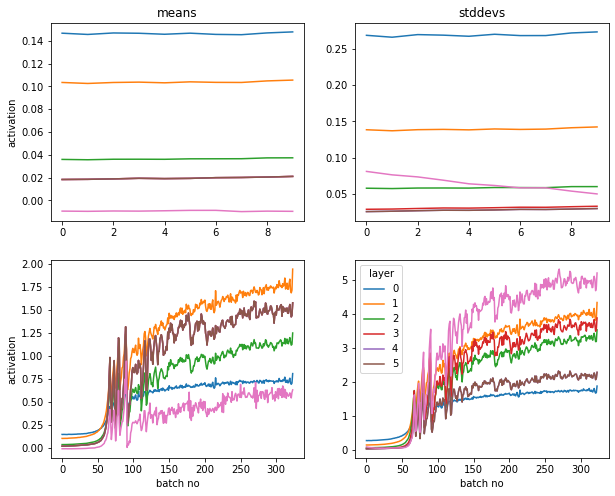

In [49]:
plot_results()

## With Kaiming

In [53]:
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

train: [0.806766796875]
valid: [0.273926171875]
train: [0.21550794921875]
valid: [0.14219842529296875]
train: [0.14123017578125]
valid: [0.10961446533203124]


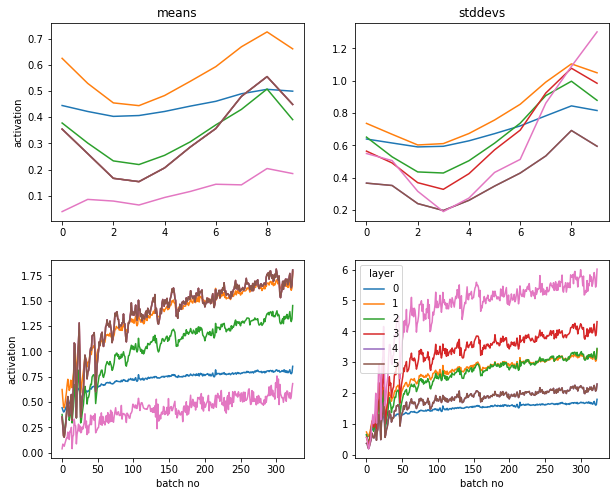

In [54]:
plot_results()

Lovely. The right classroom environment has been conducive to our neurons actually using their brains. Notice the validation loss improved far quicker.